In [14]:
import random
numSeed = 42
random.seed(42)
from time import time
import numpy as np
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

from util import *
from loadFrey import *

In [15]:
numEpochs = 50
sizeBatch = 32
dimInter = 64
dimEncode = 2
stdEps = 1.0 
ratRecon = 0.995
nameOptim = 'adam'

In [16]:
xTrain, xTest = load_frey_face_dataset()
[img_rows, img_cols] = xTrain.shape[1:]
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

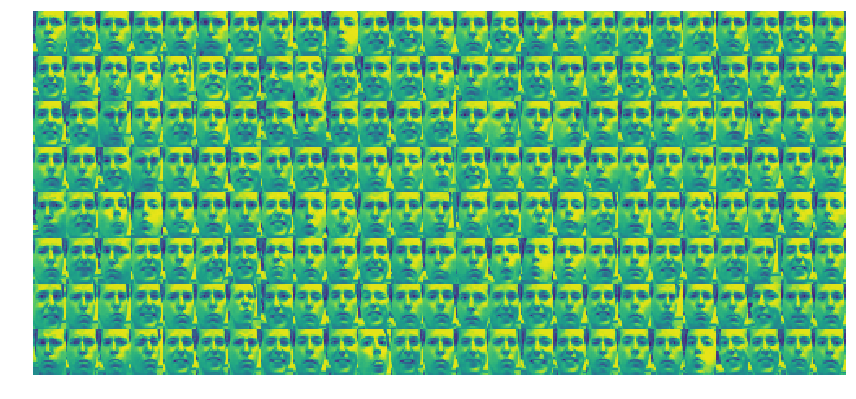

In [17]:
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()
show_examples(xTrain, n=200, n_cols=25)

In [18]:
xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(1400, 560)
(565, 560)


In [19]:
from keras import backend
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy

intermediate_dim = 256
latent_dim = 2
batch_size = 100
nb_epoch = 100
noise_std = .01
x = Input(shape=(dimInput,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [20]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = backend.random_normal(shape=(backend.shape(z_mean)[0], latent_dim), mean=0., stddev=noise_std)
    epsilon *= backend.exp(.5 * z_log_var)
    epsilon += z_mean
    return epsilon
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])    

In [21]:
decoder_h1 = Dense(intermediate_dim, activation="relu")
decoder_h2 = Dense(dimInput, activation="sigmoid")
z_decoded = decoder_h1(z)
x_decoded = decoder_h2(z_decoded)

In [22]:
vae = Model(input=x, output=x_decoded)
vae.summary()
from keras.utils import vis_utils as vizu
vizu.plot_model(vae, "ff.png", show_layer_names=False, show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 560)          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          143616      input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            514         dense_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

c:\users\user\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [23]:
# Objective function minimized by autoencoder
def vae_objective(x, x_decoded):
    loss = binary_crossentropy(x, x_decoded)
    kl_regu = -.5 * backend.sum(1. + z_log_var - backend.square(
        z_mean) - backend.exp(z_log_var), axis=-1)
    return loss + kl_regu

In [24]:
# Compile the autoencoder computation graph
vae.compile(optimizer="adam", loss=vae_objective)

c:\users\user\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 1400 samples, validate on 565 samples
Epoch 1/100
1400/1400 [==============================] - 0s 346us/step - loss: 0.6876 - val_loss: 0.6769
Epoch 2/100
1400/1400 [==============================] - 0s 47us/step - loss: 0.6567 - val_loss: 0.6252
Epoch 3/100
1400/1400 [==============================] - 0s 50us/step - loss: 0.5808 - val_loss: 0.5185
Epoch 4/100
1400/1400 [==============================] - 0s 50us/step - loss: 0.4481 - val_loss: 0.3620
Epoch 5/100
1400/1400 [==============================] - 0s 52us/step - loss: 0.2926 - val_loss: 0.2220
Epoch 6/100
1400/1400 [==============================] - 0s 49us/step - loss: 0.1783 - val_loss: 0.1378
Epoch 7/100
1400/1400 [==============================] - 0s 59us/step - loss: 0.1148 - val_loss: 0.0935
Epoch 8/100
1400/1400 [==============================] - 0s 50us/step - loss: 0.0811 - val_loss: 0.0692
Epoch 9/100
1400/1400 [==============================] - 0s 54us/step - loss: 0.0618 - val_loss: 0.0545
Epoch 10/100
140

1400/1400 [==============================] - 0s 51us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 79/100
1400/1400 [==============================] - 0s 53us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 80/100
1400/1400 [==============================] - 0s 49us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 81/100
1400/1400 [==============================] - 0s 49us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 82/100
1400/1400 [==============================] - 0s 59us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 83/100
1400/1400 [==============================] - 0s 55us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 84/100
1400/1400 [==============================] - 0s 53us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 85/100
1400/1400 [==============================] - 0s 51us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 86/100
1400/1400 [==============================] - 0s 55us/step - loss: 0.0167 - val_loss: 0.0167
Epoch 87/100
1400/1400 [==============================] - 0s 52us/st

c:\users\user\anaconda3\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


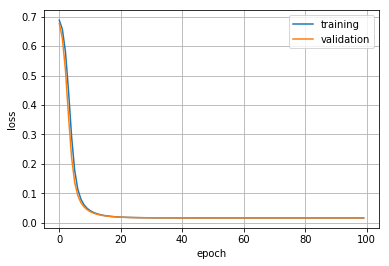

In [25]:
import os
weights_file = "../ff_%d_latent.hdf5" % latent_dim
if os.path.isfile(weights_file):
    vae.load_weights(weights_file)
else:
    from keras.callbacks import History
    hist_cb = History()
    vae.fit(xTrain, xTrain, shuffle=True, nb_epoch=nb_epoch, batch_size=batch_size,
            callbacks=[hist_cb], validation_data=(xTest, xTest))
    vae.save_weights(weights_file)
    
    # plot convergence curves to show off
    plt.plot(hist_cb.history["loss"], label="training")
    plt.plot(hist_cb.history["val_loss"], label="validation")
    plt.grid("on")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="best")

In [26]:
encoder = Model(input=x, output=z_mean)

c:\users\user\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [27]:
decoder_input = Input(shape=(latent_dim,))
h_decoded = decoder_h1(decoder_input)
x_decoded = decoder_h2(h_decoded)
generator = Model(input=decoder_input, output=x_decoded)

c:\users\user\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [29]:
from ipywidgets import FloatSlider, interact

# we will sample points within given standard deviations
humour = FloatSlider(min=-15, max=15, step=3, value=0)
pose = FloatSlider(min=-15, max=15, step=3, value=0)

@interact(pose=pose, humour=humour)
def do_thumb(humour, pose):
    z_sample = np.array([[humour, pose]]) * noise_std
    x_decoded = generator.predict(z_sample)
    face = x_decoded[0].reshape(img_rows, img_cols)
    plt.figure(figsize=(11.5, 11.5))
    ax = plt.subplot(111)
    ax.imshow(face)
    plt.axis("off")

interactive(children=(FloatSlider(value=0.0, description='humour', max=15.0, min=-15.0, step=3.0), FloatSlider(value=0.0, description='pose', max=15.0, min=-15.0, step=3.0), Output()), _dom_classes=('widget-interact',))

In [30]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io
import string
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

#Standalone generator
#Load saved model and generate new faces
#PyTorch needs this class definition after loading
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(560, 200)
        self.fc21 = nn.Linear(200, 20)
        self.fc22 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 200)
        self.fc4 = nn.Linear(200, 560)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

#Add mu, sigma so that we can read them off later
#to generate data after we disconnect the encoder
        self.mu_model = Variable(torch.cuda.FloatTensor(20), requires_grad=False)
        self.logvar_model = Variable(torch.cuda.FloatTensor(20), requires_grad=False)

        
    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        #mu, logvar = self.encode(x.view(-1, 560))

        #self.mu_model = mu
        #self.logvar_model = logvar

        #z = self.reparametrize(mu, logvar)
        
        return self.decode(z)


model = torch.load('./out/save.model')
print(model)

#get 100 random z's between 0 and -1
z = Variable(torch.randn(100,20))

print(z[0])
z = z.cuda()
x_gen = model.decode(z)



print('Generating new frey face manifold')
samples = x_gen.data.cpu().numpy()[:100]

fig = plt.figure(figsize=(10,10))
gs  = gridspec.GridSpec(10,10)
gs.update(wspace=0.01,hspace=0.01)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,20), cmap='gray')

if not os.path.exists('out/'):
    os.makedirs('out/')

plt.savefig('out/generated_manifold.png',bbox_inches='tight', cmap='gray')
plt.close(fig)

ModuleNotFoundError: No module named 'torch'